In [12]:
from unet import UNet
from train import LineSegmentationDataset
from pathlib import Path
import sys
sys.path.append("..")

run_name = "20250505_154538_unet"
experiment_folder = Path("./runs") / run_name
model = UNet.load(experiment_folder)
model = model.to("cuda")

In [6]:
from synthetic import DataGenerator, SynthSettings

gen_settings = SynthSettings(downscale_factor=0.35)
generator = DataGenerator(settings=gen_settings)
_, _, scrolls, lines = generator.generate_passages_scrolls(200)

In [22]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

def inference(scrolls, lines = None):

    track_loss = lines is not None

    if not track_loss:
        lines = np.empty((scrolls.shape[0], 0))

    data = LineSegmentationDataset(scrolls, lines)
    criterion = nn.BCEWithLogitsLoss()
    hats = []
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_scrolls, batch_lines in DataLoader(data):
            batch_scrolls, batch_lines = batch_scrolls.to("cuda"), batch_lines.to("cuda")
            lines_hat = model(batch_scrolls)
            hats.append(lines_hat.cpu().numpy())

            if track_loss:
                loss = criterion(lines_hat, batch_lines)
                test_loss.append(loss.item())


    hats = np.concatenate(hats)
    if track_loss:
        return hats, np.mean(test_loss)
    else:
        hats


hats, loss = inference(scrolls, lines)
loss

np.float64(0.060969578195363285)

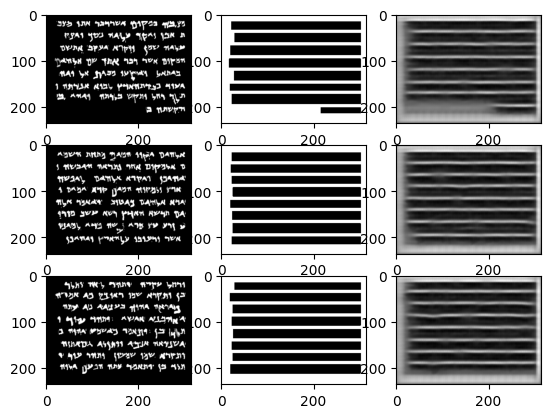

In [27]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3, 3)

inds = np.random.choice(scrolls.shape[0], size=3, replace=False)

for i, index in enumerate(inds):
    ax[i, 0].imshow(scrolls[index], cmap="binary")
    ax[i, 1].imshow(lines[index], cmap="binary")
    ax[i, 2].imshow(np.squeeze(hats[index]), cmap="binary")

plt.show()
